# **DeePTB** V2.0 | 训练Sn的紧束缚 + SOC 案例

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        作者: <a style="font-weight:normal" href="mailto:guqq@pku.edu.cn">顾强强 📨 </a> </a></b></i><br/>
        日期：2024-04-09<br/>
        共享协议：本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        快速开始：点击上方的 <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> 按钮，稍等片刻即可运行。
    </p>
</div>

<p style="color:purple; font-weight:bold">DeePTB是使用深度学习构建第一性原理精度的紧束缚（TB）模型的方法，可用于加速材料的电子结构计算。目前该软件已经迭代更新至v2.0 版本。</p>

**本教程主要介绍DeePTB 如何在non-SOC TB的基础上训练考虑SOC的TB模型**

完成本案例你将了解 DeePTB 训练SOC的流程 

关联阅读: **DeePTB** V2.0 快速上手指南 | 训练 Silicon 的紧束缚模型模型

## 1. DeePTB + SOC 方法简介

详见论文： [DeePTB paper](https://arxiv.org/abs/2307.04638)。



In [ ]:
import os
os.chdir('./examples/Sn_soc')

## 2. DeePTB 训练SOC的流程
### 2.1 数据准备
```bash
data
├── non_soc
│   ├── Sn.vasp
│   └── set.0
│       ├── eigenvalues.npy
│       ├── info.json
│       ├── kpoints.npy
│       └── xdat.traj
└── soc
    ├── Sn.vasp
    └── set.0
        ├── eigenvalues.npy
        ├── info.json
        ├── kpoints.npy
        └── xdat.traj
```


### 2.2 non-SOC TB 模型训练

因此部分和训练Si的模型一致，详见快速上手指南。

In [4]:
from dptb.nn.build import build_model
from dptb.postprocess.bandstructure.band import Band
import  matplotlib.pyplot  as plt
import numpy as np
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
from dptb.nn.nnsk import NNSK
import json
import torch

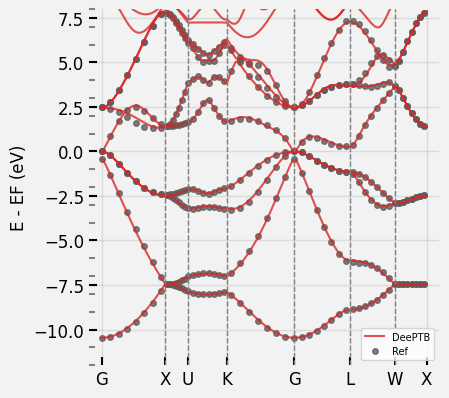

In [16]:
model = build_model(checkpoint='./reference/non_soc/v2ckpt/checkpoint/nnsk.ep100.pth')
jdata={
        "kline_type":"abacus",
        "kpath":[[0.0000000000,   0.0000000000,   0.0000000000,   30],   
                 [0.5000000000,   0.0000000000,   0.5000000000,   30],               
                 [0.6250000000,   0.2500000000,   0.6250000000,   30],    
                 [0.3750000000,   0.3750000000,   0.7500000000,   30],     
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],    
                 [0.5000000000,   0.5000000000,   0.5000000000,   30],                
                 [0.5000000000,   0.2500000000,   0.7500000000,   30],               
                 [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                 ],
        "klabels":['G','X','U','K','G','L','W','X'],
        "nel_atom":{"Sn":4},
        "E_fermi":-8.2887,
        "emin":-12,
        "emax": 8,
        "ref_band":'./data/non_soc/set.0/eigenvalues.npy'
    }
# calculate the band structure
kpath_kwargs = jdata
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            device=model.device)

stru_data = "./data/non_soc/Sn.vasp"
AtomicData_options = {"r_max": 6.0, "oer_max":3.0, "pbc": True}

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)


bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

### 2.3 加载 non-SOC TB 模型，继续训练 SOC TB 模型

修改input.json文件，添加SOC的训练参数

freeze 参数中添加 "onsite", "hopping"，表示冻结这两部分参数，只训练SOC的参数

```json
"model_options": {
        "nnsk": {
            "onsite": {"method": "strain","rs":6.0, "w": 0.1},
            "hopping": {"method": "powerlaw", "rs":6.0, "w": 0.1},
            "soc":{"method":"uniform"},
            "push": false,
            "std": 0.01,
            "freeze": ["onsite", "hopping"]
        }
    }
```

In [17]:
! dptb train input_soc_fz.json -i ./reference/non_soc/v2ckpt/checkpoint/nnsk.ep100.pth -o out_soc_fz 

Processing dataset...
Loading data:   0%|                                       | 0/1 [00:00<?, ?it/s]/Users/aisiqg/Software/venv/pydptb/lib/python3.9/site-packages/dptb/data/AtomicData.py:922: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  cell_tensor = torch.as_tensor(temp_cell, device=out_device, dtype=out_dtype)
Loading data: 100%|███████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]
DEEPTB INFO    Loaded data: Batch(atomic_numbers=[2, 1], batch=[2], bwindow=[1, 2], cell=[1, 3, 3], edge_cell_shift=[56, 3], edge_features=[56, 1], edge_index=[2, 56], edge_overlap=[56, 1], e

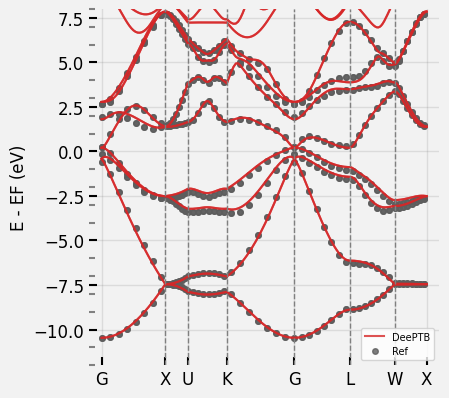

In [18]:
model = build_model(checkpoint='./out_soc_fz/checkpoint/nnsk.ep100.pth')
jdata={
        "kline_type":"abacus",
        "kpath":[[0.0000000000,   0.0000000000,   0.0000000000,   30],   
                 [0.5000000000,   0.0000000000,   0.5000000000,   30],               
                 [0.6250000000,   0.2500000000,   0.6250000000,   30],    
                 [0.3750000000,   0.3750000000,   0.7500000000,   30],     
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],    
                 [0.5000000000,   0.5000000000,   0.5000000000,   30],                
                 [0.5000000000,   0.2500000000,   0.7500000000,   30],               
                 [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                 ],
        "klabels":['G','X','U','K','G','L','W','X'],
        "nel_atom":{"Sn":4},
        "E_fermi":-8.2887,
        "emin":-12,
        "emax": 8,
        "ref_band":'./data/soc/set.0/eigenvalues.npy'
    }
# calculate the band structure
kpath_kwargs = jdata
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            device=model.device)

stru_data = "./data/non_soc/Sn.vasp"
AtomicData_options = {"r_max": 6.0, "oer_max":3.0, "pbc": True}

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)


bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])